# Sensor Confirmation in the Live Benign Setting
In this notebook we will be looking at the performance of Sensor Confirmation
in what is defined as a benign setting. A benign setting is broadly categorized
under two possible flight modes, autonomous and manual. In this work the main
focus is on autonomous flight as the attackers goal is to takeover a 
cyber-physical system that is responding to it's environment by reading various
sensors. In this notebook in particular we will be looking at the live
delivery mission and use the analysis to note what sensor pairs may be suitable
for detecting sensor spoofing and what modifications may be necessary to enable
others. The mission that was flown is displayed below:

![simulated delivery mission](../reports/figures/Live_Delivery.PNG)

## Data Processing
The log `file` needs to be parsed out as the format is irregular, starting with
a csv of rows prefixed with FMT, indicating the log type and format. The FMT
rows will be parsed into headers and then the subsequent rows will be matched
on log name, i.e., "__SNS1__", "__SNS2__", "__SNS3__" and added to their
respective dataframes. The dataframes are then unioned on their timestamps to
create a single dataframe with all of the __SNS__ data. If an `output` path is
provided the newly created dataframe will be written to the path as a CSV.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import pandas as pd
import numpy as np
from confirmation.process import process_SNS
from os.path import exists

#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "Live-C-Delivery.log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

## Attitude and Angular Rates

In the [simulation exploration notebook](./0.1-bks-exploration.ipynb) the 
generic sensors used for attitude information and angular rates, gyroscope
magnetometer and optical flow, were discussed. This section of this notebook
will simply apply the same techniques and observe the distribution of
differences in the results similar to the statistics section of the [optical
flow attack notebook](./0.1-bks-attack-idle-of.ipynb).

In [2]:
#Get rid of duplicate rows
ofMS = df[df.ofMS.shift() != df.ofMS][["ofMS","frF","frR","brF","brR", "rf", "m00", "m10"]].reset_index()
magUS = df[df.magUS.shift() != df.magUS][["magUS","magx","magy","magz"]].reset_index()
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()

#Waypoint timings are TO that waypoint, not after
WP1 = [123669579, 133794392]
WP2 = [133794392, 146764377]
WP3 = [146764377, 155079409]
WP4 = [155079409, 167619285]
WP5 = [167619285, 178059812]
#Assign relevant variables
times = [0, WP1[0]]

In [3]:
#Calculate relevant attitude/angular rate information
from confirmation.process import signal_match_and_cumsum, change_in_signal, trap_integrate, mag_to_heading, mag_to_pitch
from math import degrees

#Calculating gyroscope attitudes
gyr_heading = trap_integrate(cUS.cUS / 1000000, cUS.gyrz).apply(degrees).cumsum() % 360
gyr_pitch = trap_integrate(cUS.cUS / 1000000, cUS.gyry).apply(degrees).cumsum() % 360
gyr_roll = trap_integrate(cUS.cUS / 1000000, cUS.gyrx).apply(degrees).cumsum() % 360

In [4]:
#Calculating optical flow attitudes
of_roll = trap_integrate(ofMS.ofMS / 1000, ofMS.frR).apply(degrees).cumsum() % 360
of_pitch = trap_integrate(ofMS.ofMS / 1000, ofMS.frF).apply(degrees).cumsum() % 360

In [5]:
#Calculating magnetometer attitudes
mag_heading = mag_to_heading(magUS.magz, magUS.magy, magUS.magx)
mag_pitch = mag_to_pitch(magUS.magz, magUS.magy, magUS.magx)

### Gyroscope and Optical Flow

In [6]:
#Matching gyroscope to the optical flow update rate
gyr_of_pitch = signal_match_and_cumsum(cUS.cUS[1:].reset_index(drop=True)/1000, change_in_signal((gyr_pitch+180) % 360),
                            ofMS.ofMS[1:].reset_index(drop=True), change_in_signal((of_pitch+180) % 360))

gyr_of_pitch = pd.Series(gyr_of_pitch, name="gyr_pitch")
gyr_of_pitch = (gyr_of_pitch-180)%360
of_pitch = (of_pitch-180)%360

Taking a look at the graphs of the confirmations first to visualize what the
following results will be.

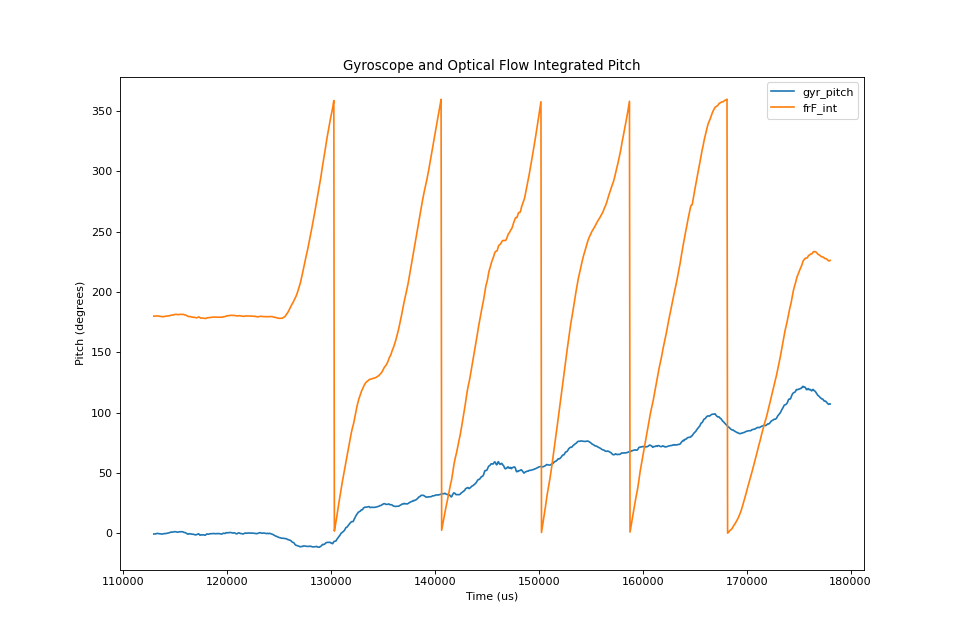

In [7]:
from confirmation.visualize import simple_time_plot
from confirmation.process import linear_bias
simple_time_plot([ofMS.ofMS[1:], ofMS.ofMS[1:]],
                 [linear_bias(ofMS.ofMS[1:].reset_index(drop=True),gyr_of_pitch, [0, WP1[0]/1000]), of_pitch],
                 ["us","Pitch (degrees)"],
                 title="Gyroscope and Optical Flow Integrated Pitch")

Admittedly this looks bad but was expected. In the 
[simulation notebook](./0.1-bks-exploration.ipynb) from early on in the
analysis it was shown that integrating the flow rate of the optical flow
pitch to get change in attitude wouldn't work. We even see the same graph shape
in the simulation notebook, matching actual results to simulated expectations.
Even accounting for body rate the optical flow sensor will be reading the flow
of the ground plane and have a consistent reading as shown in the graph above.

#### Notes for Optical Flow pitch confirmation
 * May be able to correct for pitch angle by correcting the optical flow velocity with another sensors velocity and converting that reading to angular rate. This would require another sensor for velocity, i.e., GPS or Dead reckoning, and a ranging sensor
 * May look at using the change in perceived pitch angle instead of raw angle for confirmation

In [8]:
#Matching gyroscope to the optical flow update rate
gyr_of_roll = signal_match_and_cumsum(cUS.cUS[1:].reset_index(drop=True)/1000, change_in_signal((gyr_roll+180) % 360),
                            ofMS.ofMS[1:].reset_index(drop=True), change_in_signal((of_roll+180) % 360))

gyr_of_roll = pd.Series(gyr_of_roll, name="gyr_roll")

gyr_of_roll = (gyr_of_roll+180)%360
of_roll = (of_roll+180)%360

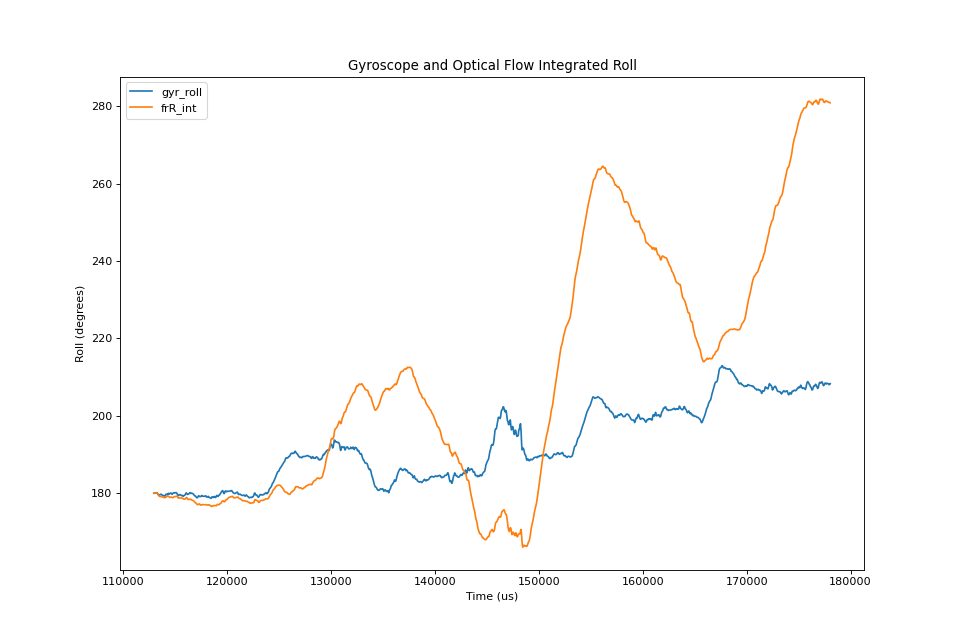

In [9]:
simple_time_plot([ofMS.ofMS[1:], ofMS.ofMS[1:]],
                 [gyr_of_roll, of_roll],
                 ["us","Roll (degrees)"],
                 title="Gyroscope and Optical Flow Integrated Roll")

### Gyroscope and Magnetometer

In [10]:
#We need the indexes that match the waypoint start and stop times
wp1_index = [magUS.magUS[magUS.magUS < WP1[0]][-1:].index[0], magUS.magUS[magUS.magUS < WP1[1]][-1:].index[0]]
wp2_index = [magUS.magUS[magUS.magUS < WP2[0]][-1:].index[0], magUS.magUS[magUS.magUS < WP2[1]][-1:].index[0]]
wp3_index = [magUS.magUS[magUS.magUS < WP3[0]][-1:].index[0], magUS.magUS[magUS.magUS < WP3[1]][-1:].index[0]]
wp4_index = [magUS.magUS[magUS.magUS < WP4[0]][-1:].index[0], magUS.magUS[magUS.magUS < WP4[1]][-1:].index[0]]
wp5_index = [magUS.magUS[magUS.magUS < WP5[0]][-1:].index[0], magUS.magUS[magUS.magUS < WP5[1]][-1:].index[0]]

#Matching gyroscope to the optical flow update rate
gyr_mag_pitch = signal_match_and_cumsum(cUS.cUS.reset_index(drop=True), change_in_signal((gyr_pitch+180)%360),
                                       magUS.magUS[1:].reset_index(drop=True), change_in_signal(mag_pitch))

gyr_mag_pitch = pd.Series(gyr_mag_pitch, name="gyr_pitch")
gyr_mag_pitch = (gyr_mag_pitch + 185) % 360

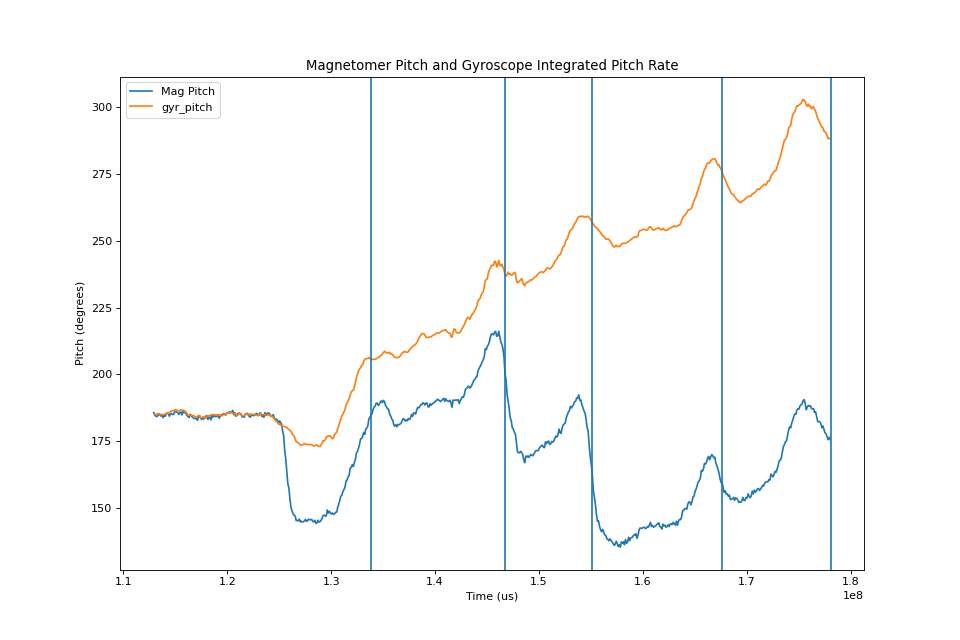

In [11]:
simple_time_plot([magUS.magUS, magUS.magUS[1:]],
                 [mag_pitch, gyr_mag_pitch],
                 ["us","Pitch (degrees)"],
                 lines=[WP1[1], WP2[1], WP3[1], WP4[1], WP5[1]],
                 title="Magnetomer Pitch and Gyroscope Integrated Pitch Rate")

This follows similarly to the optical flow and gyroscope pitch confirmation
from before in that the results from the 
[simulation notebook](./0.1-bks-exploration.ipynb) match what we are seeing
here. The notes for this confirmation still apply, where segments of activity
may be the target for confirmation rather than the absolute values. This could
also be the case where more engineering may be required since no filters have
been applied to the sensors. A sufficiently designed sensor may be able to
compensate for the drift we are seeing. This at least supports the results of
our simulations applying to reality.

#### Notes for Gyroscope pitch confirmation
 * May be able to correct for drift with a suitably designed filter, potentially a high-pass filter
 * May be viable to use a "categorical" approach for sensor confirmation, where the activity matches instead of the values

In [12]:
#Matching gyroscope to the optical flow update rate
gyr_mag_heading = signal_match_and_cumsum(cUS.cUS.reset_index(drop=True), change_in_signal((gyr_heading+180)%360),
                                       magUS.magUS[1:].reset_index(drop=True), change_in_signal(mag_heading))

gyr_mag_heading = pd.Series(gyr_mag_heading, name="gyr_heading")
gyr_mag_heading = (gyr_mag_heading+170)%360
mag_heading = (mag_heading+180)%360

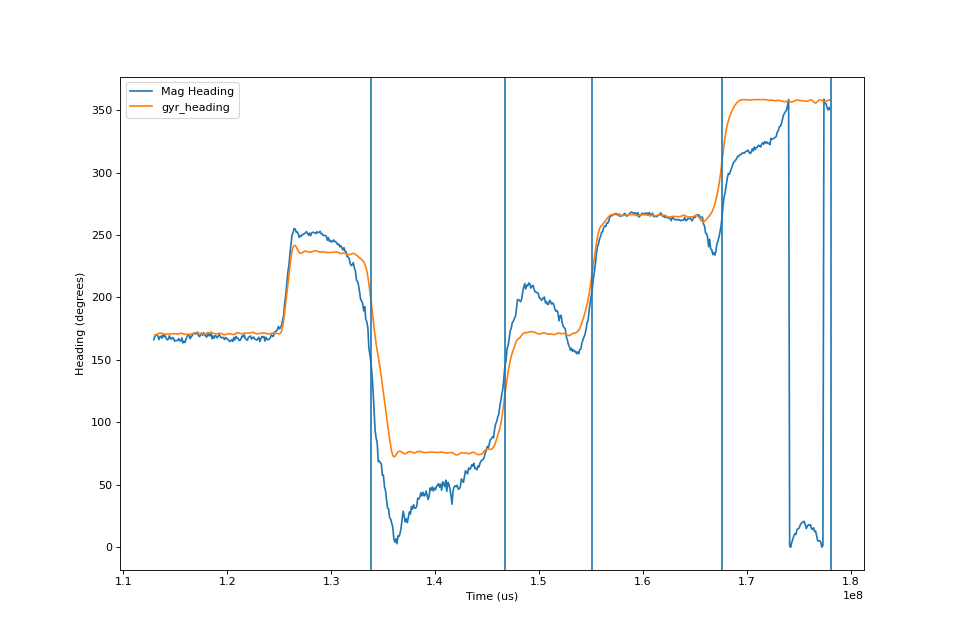

In [13]:
simple_time_plot([magUS.magUS, magUS.magUS[1:]],
                 [mag_heading, gyr_mag_heading],
                 ["us", "Heading (degrees)"],
                 lines=[WP1[1], WP2[1], WP3[1], WP4[1], WP5[1]])

In [14]:
from confirmation.process import diff
print("Gyroscope and Magnetometer")
diffs = diff(gyr_mag_heading, mag_heading, wrap=True)
print("Heading | WP1 99.7%%: %.5f degrees" % np.percentile(diffs[wp1_index[0]:wp1_index[1]].dropna(), 99.7))
print("Heading | WP2 99.7%%: %.5f degrees" % np.percentile(diffs[wp2_index[0]:wp2_index[1]].dropna(), 99.7))
print("Heading | WP3 99.7%%: %.5f degrees" % np.percentile(diffs[wp3_index[0]:wp3_index[1]].dropna(), 99.7))
print("Heading | WP4 99.7%%: %.5f degrees" % np.percentile(diffs[wp4_index[0]:wp4_index[1]].dropna(), 99.7))
print("Heading | WP5 99.7%%: %.5f degrees" % np.percentile(diffs[wp5_index[0]:wp5_index[1]].dropna(), 99.7))

Gyroscope and Magnetometer
Heading | WP1 99.7%: 43.44313 degrees
Heading | WP2 99.7%: 76.98407 degrees
Heading | WP3 99.7%: 39.34930 degrees
Heading | WP4 99.7%: 49.21841 degrees
Heading | WP5 99.7%: 52.29211 degrees


So we are seeing another problem that came up in previous analysis in the
[simulation notebook](./0.1-bks-exploration.ipynb). During turns the
magnetometer has a tendency to start swinging. Because the simulation notebook
was using simulation data and the same behavior is present in the live data,
although less erratic, it makes me believe there is something unaccounted for
in the magnetometer heading calculation. Whether the calculation is incorrect
or there are external effects being simulated, i.e., magnetic field
fluctuations due to current draw, the current heading will have large error
margins. What is necessary is to see how these margins might compare to an
attacker spoofing the gyroscope or magnetometer and what disagreements
occur then.

#### Notes for Magnetometer heading confirmation
 * May be able to correct for drift with a suitably designed filter, potentially a low-pass filter
 * Consider using the magnet we have in lab to disrupt the magnetometer. Less of a spoofing attack but will still cause magnetic fluctuations from an outside source that we may use to detect an "attack"

## Position, Velocity, and Acceleration

In the [simulation exploration notebook](./0.1-bks-exploration.ipynb) the 
generic sensors used for position, velocity, and acceleration were discussed.
This section of the notebook will apply some of the discussed techniques as
well as introduce new ones that weren't implemented in the simulation notebook.
Our main interest is the systems that provide navigation information such as
the dead reckoning system, optical flow system, and GPS. Some tertiary sensors
that can be leveraged for confirmation will be viewed as well, specifically
those discussed for altitude estimation in the
[rangefinder spoofing notebook](./0.1-bks-attack-idle-rf.ipynb).

We will primarily look at velocity in the below section as it is a single
derivative or integral to go to either position or acceleration. The only
important difference in what measurement is being confirmed is what error
may accrue due to integration drift.

In [15]:
from math import floor

#window size where window is in seconds
window = 1
imu_size = floor(window * 1000000/cUS.cUS.diff().mean())
of_size = floor(window * 1000/ofMS.ofMS.diff().mean())
gps_size = floor(window * 1000/gpsMS.gpsMS.diff().mean())

### GPS
We first consider the GPS. The gps was mentioned previously in the 
[simulation exploration notebook](./0.1-bks-benign.ipynb) was the details were
not fleshed out.

#### Satellite Navigation
An important naming convention to clarify is that a GPS is not
the name of the device globally. GPS refers to the american constellation of
satellites for positioning data which not every country uses. Some other
constellations include Galileo and GLONASS. In this notebook we will refer to
GPS primarily as it is the constellation our receivers use in experimentation.

#### From Position to Velocity
A GPS provides position information on earth using distance information from
the receiver to at least four different satellites, a process commonly referred
to as quadrilateration. Additional satellites may be used to improve the
position estimate. The result of the quadrilteration is a point on the World
Geodetic System 1984 (WGS84) which acts as the GPS reference coordinate system.
The point is represented as a geodetic point with latitude, longitude, and
altitude. The geodetic point by itself can be considered the only absolute
position information of the drone on Earth. Subsequent GPS readings can be
differenced from previous GPS readings to derive a change in position which can
further be translated to a North, East, and Down directed velocity, i.e.,
velocity vector in the Earth-Centered Earth-Fixed (ECEF) with a North-East-Down
(NED) frame. There is additional translation in the background to get from a
geodetic point to a relative velocity vector such as scaling longitude from
latitude but those details will be left out. For additional information
refer to the processing functions that perform the translation.

#### What to Expect
The mission path starts by moving Northwest to the 1st waypoint, then flies
South, West, North, and East to finish the mission. The waypoint speed is set
to 10m/s in parameters. Below the velocity of the North, East, and Down axis
are shown:

In [40]:
from confirmation.process import geodetic2ned

gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = change_in_signal(gps.North)/(gpsMS.gpsMS.diff().mean()/1000)
gps_east = change_in_signal(gps.East)/(gpsMS.gpsMS.diff().mean()/1000)
gps_down = change_in_signal(gps.Down/100)/(gpsMS.gpsMS.diff().mean()/1000)

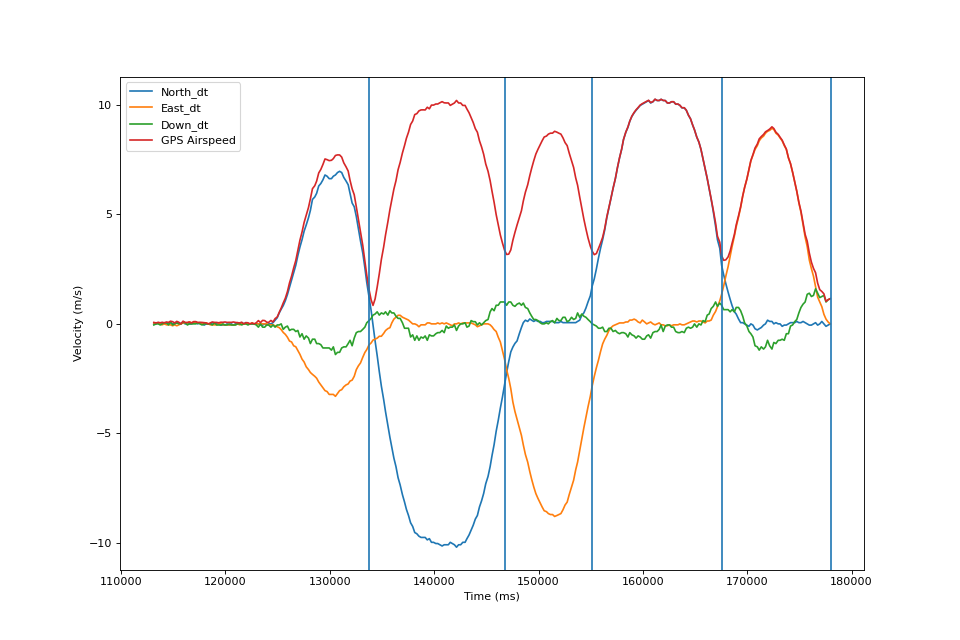

In [43]:
from confirmation.process import length

simple_time_plot([gpsMS.gpsMS[1:], gpsMS.gpsMS[1:], gpsMS.gpsMS[1:], gpsMS.gpsMS[1:]],
                 [gps_north, gps_east, gps_down, length([gps_north, gps_east, gps_down], name="GPS Airspeed")],
                 ["ms","Velocity (m/s)"],
                 lines=[WP1[1]/1000, WP2[1]/1000, WP3[1]/1000, WP4[1]/1000, WP5[1]/1000])

The GPS data, having been converted from geodetic coordinates to NED frame,
follows relatively well to expectations. The waypoint speed setting was set to
10 m/s which the flight mostly follows. Worth mentioning that the East/West
directed points were shorter and not able to actually reach the 10 m/s limit
before slowing for the next turn. Overall the GPS data matches expectations.

### Dead reckoning
We will need to confirm that we are getting the expected results out of our
dead reckoning system with the IMU and Magnetometer.

c:\nextcloud\documents\ku\padlock\code\sensorconfirmation\src\confirmation\visualize.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=figsize, dpi=80)


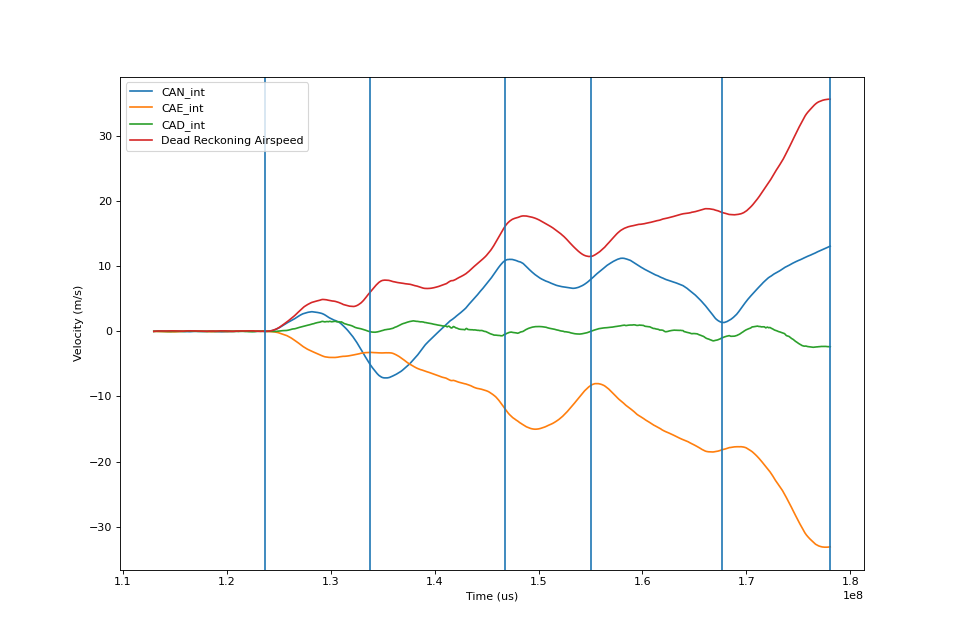

In [44]:
from confirmation.process import linear_bias
#Trapezoidal integration of acclerometer values gives the change in velocity between updates.
#Cumulative summation of change in velocity gives velocity at a given time assuming intial
#velocity was 0
acc_north = trap_integrate(cUS.cUS/1000000, linear_bias(cUS.cUS, cUS["CAN"], times)).cumsum()
acc_east = trap_integrate(cUS.cUS/1000000,linear_bias(cUS.cUS, cUS["CAE"], times)).cumsum()
acc_down = trap_integrate(cUS.cUS/1000000, linear_bias(cUS.cUS, -cUS["CAD"], times)).cumsum()
acc_as = length([acc_north, acc_east, acc_down], name="Dead Reckoning Airspeed")

simple_time_plot([cUS.cUS[1:], cUS.cUS[1:], cUS.cUS[1:], cUS.cUS[1:]],
                 [acc_north, acc_east, acc_down, acc_as],
                 units=["us", "Velocity (m/s)"],
                 lines=[WP1[0], WP1[1], WP2[1], WP3[1], WP4[1], WP5[1]])

In [131]:
from confirmation.process import linear_bias
#Trapezoidal integration of acclerometer values gives the change in velocity between updates.
#Cumulative summation of change in velocity gives velocity at a given time assuming intial
#velocity was 0
best_window = 11
best_diff = 1000
for i in np.arange(0.6, 10, 0.2):
    acc_size = floor(i * 1000000/cUS.cUS.diff().mean())
    gps_size = floor(i * 1000/gpsMS.gpsMS.diff().mean())
    acc_n = trap_integrate(cUS.cUS/1000000, linear_bias(cUS.cUS, cUS["CAN"], times)).rolling(acc_size).sum()
    gps_n = change_in_signal(gps_north).rolling(gps_size).sum()

    acc_gps_n = signal_match_and_cumsum(cUS.cUS[acc_size+1:].reset_index(drop=True)/1000, change_in_signal(acc_n[acc_size:].reset_index(drop=True)),
                                        gpsMS.gpsMS[gps_size+2:].reset_index(drop=True), change_in_signal(gps_n[gps_size:].reset_index(drop=True)))
    acc_gps_n = pd.Series(acc_gps_n, name="acc_gps_n", dtype='float64')
    max_diff = abs(acc_gps_n - gps_n[gps_size:].reset_index(drop=True)).max()
    if max_diff < best_diff:
        best_window = i
        best_diff = max_diff

signal_match_and_cumsum:   0%|          | 0/318 [00:00<?, ?it/s]

KeyboardInterrupt: 

Admittedly the Dead reckoning results appear far worse than previous
experiments would suggest. The general idea here is to take the already
rotated accelerometer readings and to perform trapezoidal integration.
The resulting series represents the change in velocity at each accelerometer
update step. Cumulatively summing the series should then result in the velocity
at a given timestep. What we are seeing instead is most likely an extreme case
of integration drift and may warrant applying filtering techniques from
literature.

### Optical Flow
Optical Flow can be compared to dead reckoning without additional sensors
because both sensors are mounted in the body reference frame. In order to
compare optical flow with the GPS a magnetometer and/or gyropscope needs
to be added to translate from body frame to NED frame. Considering the
results we had in confirming the attitude with an optical flow sensor I
would anticipate the optical flow velocity to follow the GPS patterns
fairly well but with different scaling due to tilt.

In [ ]:
from confirmation.process import body_to_earth2D

#Convert optical flow and rangefinder to OF Velocity in body frame
of_vel_bf = pd.DataFrame(data={"OF Forward":ofMS.frF * ofMS.rf/100,
                               "OF Right":ofMS.frR * ofMS.rf/100})

earth_frame = body_to_earth2D(of_vel_bf["OF Forward"], of_vel_bf["OF Right"], ofMS.m00, ofMS.m10)

simple_time_plot([ofMS.ofMS, ofMS.ofMS, ofMS.ofMS],
                 [earth_frame.North, earth_frame.East, length([earth_frame.North, earth_frame.East])],
                 units=["ms", "Velocity (m/s)"],
                 title="Velocity Derived From Optical Flow",
                 lines=[WP1[0]/1000, WP1[1]/1000, WP2[1]/1000, WP3[1]/1000, WP4[1]/1000, WP5[1]/1000])

Surprisingly optical flow looks like it gives genuinely good data even if the
signal is noisy. We see deviation up to 5 m/s but the average of the signal at
those points track well to the values we were seeing in the GPS results. Even
better is the optical flow showing a peak reading of 10 m/s which represents
the desired max velocity that was only reached a few times in testing. The
optical flow sensor has shown itself to be usable and with some mild filtering,
not to the extent of the dead reckoning system, should prove useful in
confirming to the other velocity sensors.

__important note:__ These promising results also motivates the idea of using
an airspeed reading from another sensor to derive a perceived flow rate due to
actual motion to compensate for the constant pitch seen previously when looking
at attitude.

## Above-Ground-Level
One of the implemented attacks was rangefinder spoofing which was shown to be
extremely effective at influencing the drones behavior. The ability to detect
the attack when the drone was idle went well and will be repeated here to see
how flying a mission influences the reliability of the above-ground-level
confirmations.

In [ ]:
from math import floor
from confirmation.process import low_pass_filter

rfMS = df[df.rfMS.shift() != df.rfMS][["rfMS","rf"]].reset_index(drop=True)
barms = df[df.barms.shift() != df.barms][["barms","bara"]].reset_index(drop=True)
window_seconds = 2

#Each signal has different window size
acc_size = floor(window_seconds * 1000000/cUS.cUS.diff().mean())
rf_size = floor(window_seconds * 1000/rfMS.rfMS.diff().mean())
gps_size = floor(window_seconds * 1000/gpsMS.gpsMS.diff().mean())
bar_size = floor(window_seconds * 1000/barms.barms.diff().mean())

#Negate downward accelerometer because up is positive for other 3 sensors
acc_alt = trap_integrate(cUS.cUS/1000000, linear_bias(cUS.cUS, -cUS["CAD"], times)).cumsum()
acc_alt = trap_integrate(cUS.cUS[1:].reset_index(drop=True)/1000000, acc_alt).cumsum()

bar_alt = change_in_signal(barms.bara)
rf_alt = change_in_signal(rfMS.rf/100)
gp_alt = change_in_signal(gpsMS.gpAlt/100)

times = [0, WP1[0]]
simple_time_plot([barms.barms[1:],
                  rfMS.rfMS[1:],
                  gpsMS.gpsMS[1:],
                  cUS.cUS[2:]/1000],
                 [bar_alt.cumsum(),
                  linear_bias(rfMS.rfMS[1:].reset_index(drop=True), rf_alt, [0, times[1]/1000]).cumsum(),
                  gp_alt.cumsum(),
                  acc_alt],
                title="Cumulative Change in Altitude with Biasing and Rolling Window",
                units=["ms","Above Ground Level (m)"],
                lines=[WP1[0]/1000, WP1[1]/1000, WP2[1]/1000, WP3[1]/1000, WP4[1]/1000, WP5[1]/1000])

We see there is performance degradation of the above-ground-level confirmations
during an actual flight. Most prominent is the degradation in the dead
reckoning above-ground-level measurement which was to be expected considering
the results of the previous dead reckoning measurements.The barometer continues
to be spikey and coudl use a filter to smooth the data out but overall looks
usable for confirmation. The rangefinder and GPS both track surprisingly well
with the rangefinder having a slightly higher reading which was to be
expected. Since the quadcopter has to tilt to fly anywhere the rangefinder will
end up reading more range than is actually directly below the quadcopter. The
effect can be compensated somewhat by putting a max scale value based on tilt
derived from the rotation matrix but was not done here.

## Summary Table
Provided below is a summary of what confirmations are possible. Not every
possible confirmation is listed, i.e., measuring tilt with an accelerometer,
but the high level groupings are listed.

✅=Works

⏳=Would require some work

⛔=Would require significant work, possibly implementing state-of-the-art techniques

|                           | **Idle** | **Delivery** |
|---------------------------|----------|------------|
| **Dead Reckoning**        | ✅        | ⛔           |
| **GPS**                   | ✅        | ✅          |
| **Optical Flow Velocity** | ✅        | ✅          |
| **Gyroscope**             | ✅        | ✅          |
| **Magnetometer**          | ✅        | ✅          |
| **Optical Flow Rate**     | ✅        | ⏳ / ✅          |
| **Rangefinder Height**    | ✅        | ✅          |
| **GPS Height**            | ✅        | ✅          |
| **Dead Reckoning Height** | ✅        | ⛔           |
| **Barometer Height**      | ⏳        | ⏳          |

We will look into the sensor giving us trouble down below.

### Looking at Optical Flow Velocity
Ideally there would be 2 viable sensors for each type of confirmation, i.e.,
velocity, attitude, and height. From the summary table we see that height is
already covered but velocity and attitude suffer during movement. Here we can
see that the optical flow velocity is marked as ~requiring some work~(updated
to checkmark), which we will address below. An initial overview of optical flow
velocity shows that the signal matches GPS relatively well except for how noisy
the signal is. We will approach the optical flow velocity with a low pass
filter to try and remove as much noise as possible. We have some leeway with
the filter because the optical flow operates at a much higher rate than the
GPS, allowing us to update the sensor slower.

In [ ]:
#Convert optical flow and rangefinder to OF Velocity in body frame
of_vel_bf = pd.DataFrame(data={"OF Forward":(ofMS.frF - ofMS.brF) * ofMS.rf/100,
                               "OF Right":(ofMS.frR - ofMS.brR) * ofMS.rf/100})

earth_frame = body_to_earth2D(of_vel_bf["OF Forward"], of_vel_bf["OF Right"], ofMS.m00, ofMS.m10)

lpf_E = -low_pass_filter(earth_frame.East, alpha=0.2)
lpf_N = low_pass_filter(earth_frame.North, alpha=0.2)

simple_time_plot([ofMS.ofMS, ofMS.ofMS, gpsMS.gpsMS[1:], gpsMS.gpsMS[1:]],
                 [lpf_N, lpf_E, gps_north, gps_east],
                 units=["ms", "Velocity (m/s)"],
                 title="Velocity Derived From Optical Flow",
                 lines=[WP1[0]/1000, WP1[1]/1000, WP2[1]/1000, WP3[1]/1000, WP4[1]/1000, WP5[1]/1000])

In [ ]:
#Matching gyroscope to the optical flow update rate
of_gps_N = signal_match_and_cumsum(ofMS.ofMS, change_in_signal(lpf_N),
                                    gpsMS.gpsMS[1:].reset_index(drop=True), change_in_signal(gps_north))
of_gps_E = signal_match_and_cumsum(ofMS.ofMS, change_in_signal(lpf_E),
                                    gpsMS.gpsMS[1:].reset_index(drop=True), change_in_signal(gps_east))

of_gps_N = pd.Series(of_gps_N, name="OF North")
of_gps_E = pd.Series(of_gps_E, name="OF East")

#Calculate the value at which 99.7% of points fall below for both the benign
#and attacked setting
print("North | OF and GPS 99.7%%: %.5f m/s" % np.percentile(abs(of_gps_N - gps_north).dropna(), 99.7))
print("East  | OF and GPS 99.7%%: %.5f m/s" % np.percentile(abs(of_gps_E - gps_east).dropna(), 99.7))

Admittedly the results are a wide range if we use the worst performing axis,
giving 3.24 m/s of disagreement between the OF and the GPS. The performance is
not all too surprising however as the pitching and rolling of the drone to
change directions will increase the error margins of the OF derived velocity.
In the idle test case when the GPS was spoofed a margin of 3.24 m/s would 
detect an attack of 0.50 m/s after 6.5 seconds, or ~8m of deviation. I would
assume this performance would be worse as the attack get stealthier, even to
the point of being undetected considering we are watching the velocity. There
is a case for monitoring the position deviation instead which would follow
similarly to a previously proposed "consistent deviation" detection. Watching
for change in position deviation would be similar to watching for a consistent
disagreement in velocity which could be worth exploring.

#### OF Summary
I would consider the sensor a valid system for confirmation to velocity. There
are different engineering methods that haven't been applied that could improve
the performance further such as more complex filtering algorithms or the
disagreement budget approach. However, we see here that the approach can
detect the constant 0.50 m/s offset after 8m of deviation which is good for a
subtle attack.

### Looking at Flow Rate (Roll/Pitch) with Speed Correction
~~From the summary table we see that the attitude has Gyroscope and Optical Flow
as potential candidates. Here we are looking at Optical Flow since the sensor
exhibits the expected behavior but a consequence of movement is flow rate
readings that don't correspond to attitude but rather ground plane angular
displacement. What we are experimenting with here is the idea of using a
tertiary sensor that the confirmation does not actively use, i.e., if paired
with gyroscope don't use accelerometer, to calculate the flow rate from
airspeed. The example we will work with below will correct the flow rate with
GPS airspeed which will hopefully give a flow rate representing attitude rather
then ground plane displacement.~~

~~**Would need a new airspeed sensor to make this work. GPS relies on
magnetometer or gyroscope while dead-reckoning is unstable as currently
implemented. This topic should be revisited if the dead-reckoning system is
fixed. I will leave the code here for now.**~~

I've come back to this again. If we consider just airspeed provided by GPS and
ignore the reference frame we will most likely incur a large error during
turns since the airspeed won't only be along a single axis or two axis if we
account for vertical movement. However, we might be able to compensate for some
of the error by normalizing the front/right flow rate and then distributing the
airspeed according to their normalized weight. We will consider simply removing
total airspeed from the front flow rate first before attempting any normalized
weights.

In [ ]:
from confirmation.process import earth_to_body2D

#Convert GPS from Earth Frame to Body Frame
gps_earth = earth_to_body2D(gps_north, gps_east, gpsMS.m00[1:].reset_index(drop=True), gpsMS.m10[1:].reset_index(drop=True))

#Match Flow Rate and Rangefinder to GPS
of_gps_F = signal_match_and_cumsum(ofMS.ofMS, change_in_signal(low_pass_filter(ofMS.frF, alpha=0.2)),
                                    gpsMS.gpsMS[1:].reset_index(drop=True), change_in_signal(gps_north))
of_gps_R = signal_match_and_cumsum(ofMS.ofMS, change_in_signal(low_pass_filter(ofMS.frR, alpha=0.2)),
                                    gpsMS.gpsMS[1:].reset_index(drop=True), change_in_signal(gps_east))

In [ ]:
rf_gps = (signal_match_and_cumsum(rfMS.rfMS, change_in_signal(rfMS.rf),
                                    gpsMS.gpsMS[1:].reset_index(drop=True), change_in_signal(gps_north)) + rfMS.rf[0])/100
rf_gps = pd.Series(rf_gps, name="rf gps")

In [ ]:
#Matching magnetometer to the gps update rate
mag_pitch
gyr_gps_pitch = signal_match_and_cumsum(cUS.cUS[1:].reset_index(drop=True)/1000, change_in_signal((gyr_pitch+180) % 360),
                                        gpsMS.gpsMS[1:].reset_index(drop=True), change_in_signal(gps_north))

gyr_gps_pitch = pd.Series(gyr_gps_pitch, name="gyr_pitch")
gyr_gps_pitch = (gyr_gps_pitch-180)%360

In [ ]:
#Calculate correction flow rate from GPS airspeed and Rangefinder
gps_as = length([gps_earth.Front, gps_earth.Right], name="gps_as")
of_gps_pitch = (of_gps_F - gps_as.divide(rf_gps)).rename("Flow Rate Forward with GPS Correction")
simple_time_plot([gpsMS.gpsMS[1:], ofMS.ofMS],
                 [of_gps_pitch, ofMS.frF.rename("Flow Rate Forward")],
                 units=["ms","Flow (radians)"],
                 title="Comparing Flow Rate Before and After GPS Correction.")

In [ ]:
of_pitch = (trap_integrate(gpsMS.gpsMS / 1000, of_gps_pitch).apply(degrees).cumsum() + 185) % 360

simple_time_plot([magUS.magUS/1000,
                  gpsMS.gpsMS[2:],
                  ofMS.ofMS[1:]],
                 [mag_pitch.rename("Magnetometer Pitch"),
                  of_pitch.rename("OF Pitch with GPS Correction"),
                  ((trap_integrate(ofMS.ofMS / 1000, ofMS.frF).apply(degrees).cumsum() - 180) % 360).rename("Original OF Pitch")],
                 ["ms","Pitch (degrees)"],
                 title="Pitch Comparison for Before and After GPS Correction (Mag vs OF)")

### Looking at the IMU (Dead reckoning) with LPF testing
We've used the IMU before but we didn't explore exactly how much LPF can help.
Low pass filters are a common method of removing DC Bias which is what we are
looking at here. To start we will just brute force a bunch of LPF values and
see if that smooths out the signal a bit. We will consider the magnetometer
results as the true signal and minimize the difference between magnetometer
attitude and gyroscope attitude.

In [ ]:
#Matching gyroscope to the optical flow update rate
gyr_mag_pitch = signal_match_and_cumsum(cUS.cUS.reset_index(drop=True), change_in_signal((gyr_pitch+180)%360),
                                       magUS.magUS[1:].reset_index(drop=True), change_in_signal(mag_pitch))

gyr_mag_pitch = pd.Series(gyr_mag_pitch, name="gyr_pitch")
gyr_mag_pitch = (gyr_mag_pitch + 185) % 360

In [ ]:
from tqdm.notebook import trange
best_describe = (mag_pitch - gyr_mag_pitch)[100:]
best_alpha = 0
for alpha in trange(1000):
    current_describe = (gyr_mag_pitch[100:] - low_pass_filter(gyr_mag_pitch, alpha/1000)[100:] - mag_pitch[100:])
    if current_describe.abs().max() < best_describe.abs().max():
        best_alpha = alpha
        best_describe = current_describe

In [ ]:
simple_time_plot([magUS.magUS, magUS.magUS[1:], magUS.magUS[1:]],
                 [mag_pitch, low_pass_filter(gyr_mag_pitch, 0.2), (gyr_mag_pitch - low_pass_filter(gyr_mag_pitch, best_alpha/1000)).rename("Subtracted LPF Bias")],
                 ["us","Pitch (degrees)"],
                 lines=[WP1[1], WP2[1], WP3[1], WP4[1], WP5[1]],
                 title="Magnetomer Pitch and Gyroscope Integrated Pitch Rate")

In [ ]:
(mag_pitch[200:] - (gyr_mag_pitch - low_pass_filter(gyr_mag_pitch, best_alpha/1000))[200:]).describe()

The best performing parameter for the filter was approximately 0.001. The max
difference during the benign flight was 31 degrees which is fairly significant
but may be sufficient for detecting an attack on the gyroscope or magnetometer.
For consistency we will show the heading comparison for gyroscope and
magnetometer again below. The filter won't be applied since hte heading
doesn't suffer from drift like the other attitudes did.

In [ ]:
#Matching gyroscope to the optical flow update rate
gyr_mag_heading = signal_match_and_cumsum(cUS.cUS.reset_index(drop=True), change_in_signal((gyr_heading+180)%360),
                                       magUS.magUS[1:].reset_index(drop=True), change_in_signal(mag_heading))

gyr_mag_heading = pd.Series(gyr_mag_heading, name="gyr_heading")
gyr_mag_heading = (gyr_mag_heading+170)%360
simple_time_plot([magUS.magUS, magUS.magUS[1:]],
                 [mag_heading, gyr_mag_heading],
                 ["us", "Heading (degrees)"],
                 lines=[WP1[1], WP2[1], WP3[1], WP4[1], WP5[1]])

In [ ]:
from confirmation.process import diff
diff(gyr_mag_heading, mag_heading, wrap=True).describe()

A 79 degree difference during benign flight isn't a great result but it does
at least mean that gyroscope and magnetometer confirming each other can prevent
the drone from being turned around by an adversary.